In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparing data
### Loading the review spreasheet as a multi-index (tsv)

In [2]:
base = pd.read_csv("../InterfaceReview-May2019.tsv", sep="\t", index_col= [0,1], skipinitialspace=True)

In [ ]:
base.head()

### Testing some indexing

In [ ]:
base.loc['apis','IIIF Image API']

In [ ]:
base.loc['information on digitization','OCR confidence scores'].describe()

In [ ]:
base.loc['newspaper metadata','Place of publication']

In [ ]:
# counts will not work for categorical data
base.loc['newspaper collection', 'Languages of the collections']

### Do some cleaning
#### Trim string to be sure

In [3]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if type(x) is str else x
    return df.applymap(trim_strings)

# trim
base = trim_all_columns(base)

#### Remove undesirable rows (i.e. not entirely binary)

In [4]:
base = base.drop('interface', level=0)
base = base.drop('newspaper collection', level=0)
base = base.drop('Other', level=1)
base = base.drop('Languages of the collections', level=1)
base = base.drop('Download options (file formats)', level=1)

#### Replace n and y by 0 and 1 (ideally to clean in spreadsheet)

In [5]:
base = base.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?'], value=[1,1,1,1,0,0,0,0])

In [ ]:
base.head()

## Radar factory

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, fontsize):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=fontsize)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [7]:
def build_single_radar(labels, values, title, grid, figure_title):
    N = len(labels)
    theta = radar_factory(N, frame='polygon')
    
    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)

    #ax.set_rgrids([2, 4, 6, 8])
    ax.set_rgrids(grid, labels=[str(i) for i in grid], size='large')
    ax.set_title(title,  position=(0.5, 1.1), ha='center')

    for d in values:
        line = ax.plot(theta, d)
        ax.fill(theta, d,  alpha=0.25)
    ax.set_varlabels(labels, fontsize=12)
    
    if figure_title is None:
        plt.show()
    else:
        plt.savefig(f'{figure_title}.png')

In [8]:
def build_multiple_radar(labels, values, titles, grid, figure_title):
    N = len(labels)
    theta = radar_factory(N, frame='polygon')
        
    fig, axes = plt.subplots(figsize=(120, 80), nrows=4, ncols=6,
                             subplot_kw=dict(projection='radar'))
    
    fig.subplots_adjust(wspace=0.35, hspace=0.20, top=0.85, bottom=0.05)

    for ax, case_data, title in zip(axes.flatten(), values, titles):
        #ax.set_rgrids(['2', '4', '6', '8'])
        #ax.set_rgrids(grid, labels=[str(i) for i in grid], size='large')
        ax.set_title(title, weight='bold', fontsize=42, position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        #for d in case_data:
        line = ax.plot(theta, case_data)
        ax.fill(theta, case_data,  alpha=0.25)
        ax.set_varlabels(labels, fontsize=32)

   # fig.suptitle('Historic Newspapers Interfaces Features', fontsize=36, size='large')
    #fig.text(0.5, 0.965, 'Historic Newspapers Interfaces Features',
    #         horizontalalignment='center', color='black', weight='bold',
    #         size='large')
    #plt.show() , bbox_inches='tight'
    #plt.rcParams.update({'font.size': 32})
    if figure_title is None:
        plt.show()
    else:
        plt.savefig(f'{figure_title}.png')

In [31]:
def build_multiple_radar_even(labels, values, titles, grid, figure_title):
    N = len(labels)
    theta = radar_factory(N, frame='polygon')
        
    fig, axes = plt.subplots(figsize=(120, 80), nrows=4, ncols=6,
                             subplot_kw=dict(projection='radar'))
    
    fig.subplots_adjust(wspace=0.35, hspace=0.20, top=0.85, bottom=0.05)

    for ax, case_data, title in zip(axes.flatten(), values, titles):
        #ax.set_rgrids(['1', '2', '3', '4', '5', '6', '7', '8', '9','10'])
        ax.set_ylim(0, 30)
        #ax.set_yscale('log')
        #ax.set_rgrids(grid, labels=[str(i) for i in grid], size='large')
        ax.set_title(title, weight='bold', fontsize=42, position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        #for d in case_data:
        line = ax.plot(theta, case_data)
        ax.fill(theta, case_data,  alpha=0.25)
        ax.set_varlabels(labels, fontsize=32)

   # fig.suptitle('Historic Newspapers Interfaces Features', fontsize=36, size='large')
    #fig.text(0.5, 0.965, 'Historic Newspapers Interfaces Features',
    #         horizontalalignment='center', color='black', weight='bold',
    #         size='large')
    #plt.show() , bbox_inches='tight'
    #plt.rcParams.update({'font.size': 32})
    if figure_title is None:
        plt.show()
    else:
        plt.savefig(f'{figure_title}.png')

## Interface charts
### Counts

#### Sum values of level 1 => 'grade' of each interface per family of features

In [10]:
level_0 = base.groupby(level=0).sum(axis=1)

In [11]:
level_0.head()

Austrian Newspapers Online (ANNO)  Ancestry  \
apis                                                         0         0   
browsing                                                     3         3   
connectivity                                                 0         0   
enrichment                                                   1         0   
information on digitization                                  2         0   

                             British Newspaper Archives  \
apis                                                  0   
browsing                                              2   
connectivity                                          0   
enrichment                                            0   
information on digitization                           3   

                             California Digital Newspaper Collection (CDNC)  \
apis                                                                      0   
browsing                                                                  4   
connectivity                                                              0   
enrichment                                                                1   
information on digitization                                               2   

                             Chronicling America  \
apis                                           1   
browsing                                       1   
connectivity                                   2   
enrichment                                     0   
information on digitization                    3   

                             Colorado Historical Newspaper Collection (CHNC)  \
apis                                                                       0   
browsing                                                                   3   
connectivity                                                               0   
enrichment                                                                 1   
information on digitization                                                1   

                             Delpher  DigiPress  DIFMOE  E-luxemburgensia  \
apis                               1          1       0                 0   
browsing                           0          2       3                 2   
connectivity                       1          0       0                 0   
enrichment                         1          0       0                 0   
information on digitization        1          1       1                 3   

                             ...  Georgia Historic Newspapers  \
apis                         ...                            2   
browsing                     ...                            4   
connectivity                 ...                            0   
enrichment                   ...                            0   
information on digitization  ...                            1   

                             Libraria - Ukrainian online periodicals archive  \
apis                                                                       0   
browsing                                                                   3   
connectivity                                                               0   
enrichment                                                                 0   
information on digitization                                                4   

                             New York Times  POLONA  Retronews  Scriptorium  \
apis                                      0       0          0            0   
browsing                                  0       2          3            0   
connectivity                              0       0          3            0   
enrichment                                0       0          5            0   
information on digitization               0       1          2            1   

                             StaBi  Tessmann  Le Temps archives  Trove  
apis                             1         0                  1  

#### Observations per feature family

In [12]:
#Total sum per row, ie. per feature family (=> how good are all interfaces for a certain aspect): 
level_0.loc[:,'Total'] = level_0.sum(axis=1)

In [13]:
level_0['Total (%)'] = level_0['Total']/level_0['Total'].sum() * 100

#### Radar/Star/Spider with just one interface

In [14]:
# getting the labels
labels = level_0.index
labels

Index(['apis', 'browsing', 'connectivity', 'enrichment',
       'information on digitization', 'newspaper metadata', 'result display',
       'result filtering', 'result sorting', 'search', 'user interaction',
       'viewer'],
      dtype='object')

In [ ]:
# Get all rows, just for the first columns, and transpose it (for the radar factory)
level_0.iloc[:12, :1].T

In [ ]:
# take only the values
first_interface = level_0.iloc[:12, :1].T.values

In [ ]:
build_single_radar(labels, values=first_interface, title=level_0.columns[0], grid=[2,4,6,8], figure_title=None)

#### Radar view for each interfaces

In [15]:
# take the data: all rows and up to the 23th columns (selecting precisely in case Total columns are added)
all_interfaces_counts = level_0.iloc[:12, :23].T.values

In [ ]:
# a radar for each interface in a figure
build_multiple_radar(labels, all_interfaces_counts, level_0.columns[:23], [2, 4, 6, 8], 'interfaces')

#### Do the same but with percentages

In [23]:
level_0_percent = base.groupby(level=0).sum(axis=1).apply(lambda x: 100*x/float(x.sum()))

In [17]:
level_0_percent

Austrian Newspapers Online (ANNO)   Ancestry  \
apis                                                       0.0   0.000000   
browsing                                                   7.5   9.677419   
connectivity                                               0.0   0.000000   
enrichment                                                 2.5   0.000000   
information on digitization                                5.0   0.000000   
newspaper metadata                                        22.5   9.677419   
result display                                             5.0  12.903226   
result filtering                                          12.5  12.903226   
result sorting                                            10.0   9.677419   
search                                                    22.5  22.580645   
user interaction                                           0.0  12.903226   
viewer                                                    12.5   9.677419   

                             British Newspaper Archives  \
apis                                           0.000000   
browsing                                       5.882353   
connectivity                                   0.000000   
enrichment                                     0.000000   
information on digitization                    8.823529   
newspaper metadata                            14.705882   
result display                                 8.823529   
result filtering                              14.705882   
result sorting                                 5.882353   
search                                        11.764706   
user interaction                              14.705882   
viewer                                        14.705882   

                             California Digital Newspaper Collection (CDNC)  \
apis                                                               0.000000   
browsing                                                           8.333333   
connectivity                                                       0.000000   
enrichment                                                         2.083333   
information on digitization                                        4.166667   
newspaper metadata                                                12.500000   
result display                                                     6.250000   
result filtering                                                  16.666667   
result sorting                                                    10.416667   
search                                                            14.583333   
user interaction                                                  14.583333   
viewer                                                            10.416667   

                             Chronicling America  \
apis                                    2.631579   
browsing                                2.631579   
connectivity                            5.263158   
enrichment                              0.000000   
information on digitization             7.894737   
newspaper metadata                     31.578947   
result display                          2.631579   
result filtering                        5.263158   
result sorting                          7.894737   
search                                 15.789474   
user interaction                        5.263158   
viewer                                 13.157895   

                             Colorado Historical Newspaper Collection (CHNC)  \
apis                                                                     0.0   
browsing                                                                 7.5   
connectivity                                                             0.0   
enrichment                                                               2.5   
information on digitization                                              2.5   
newspaper metadata                                                       5

In [ ]:
# checking we have 100 everywhere
level_0_percent.sum()

In [21]:
level_0_percent.max().max()

31.818181818181817

In [24]:
all_interfaces_percents = level_0_percent.iloc[:12, :23].T.values

In [28]:
all_interfaces_percents.max()

31.818181818181817

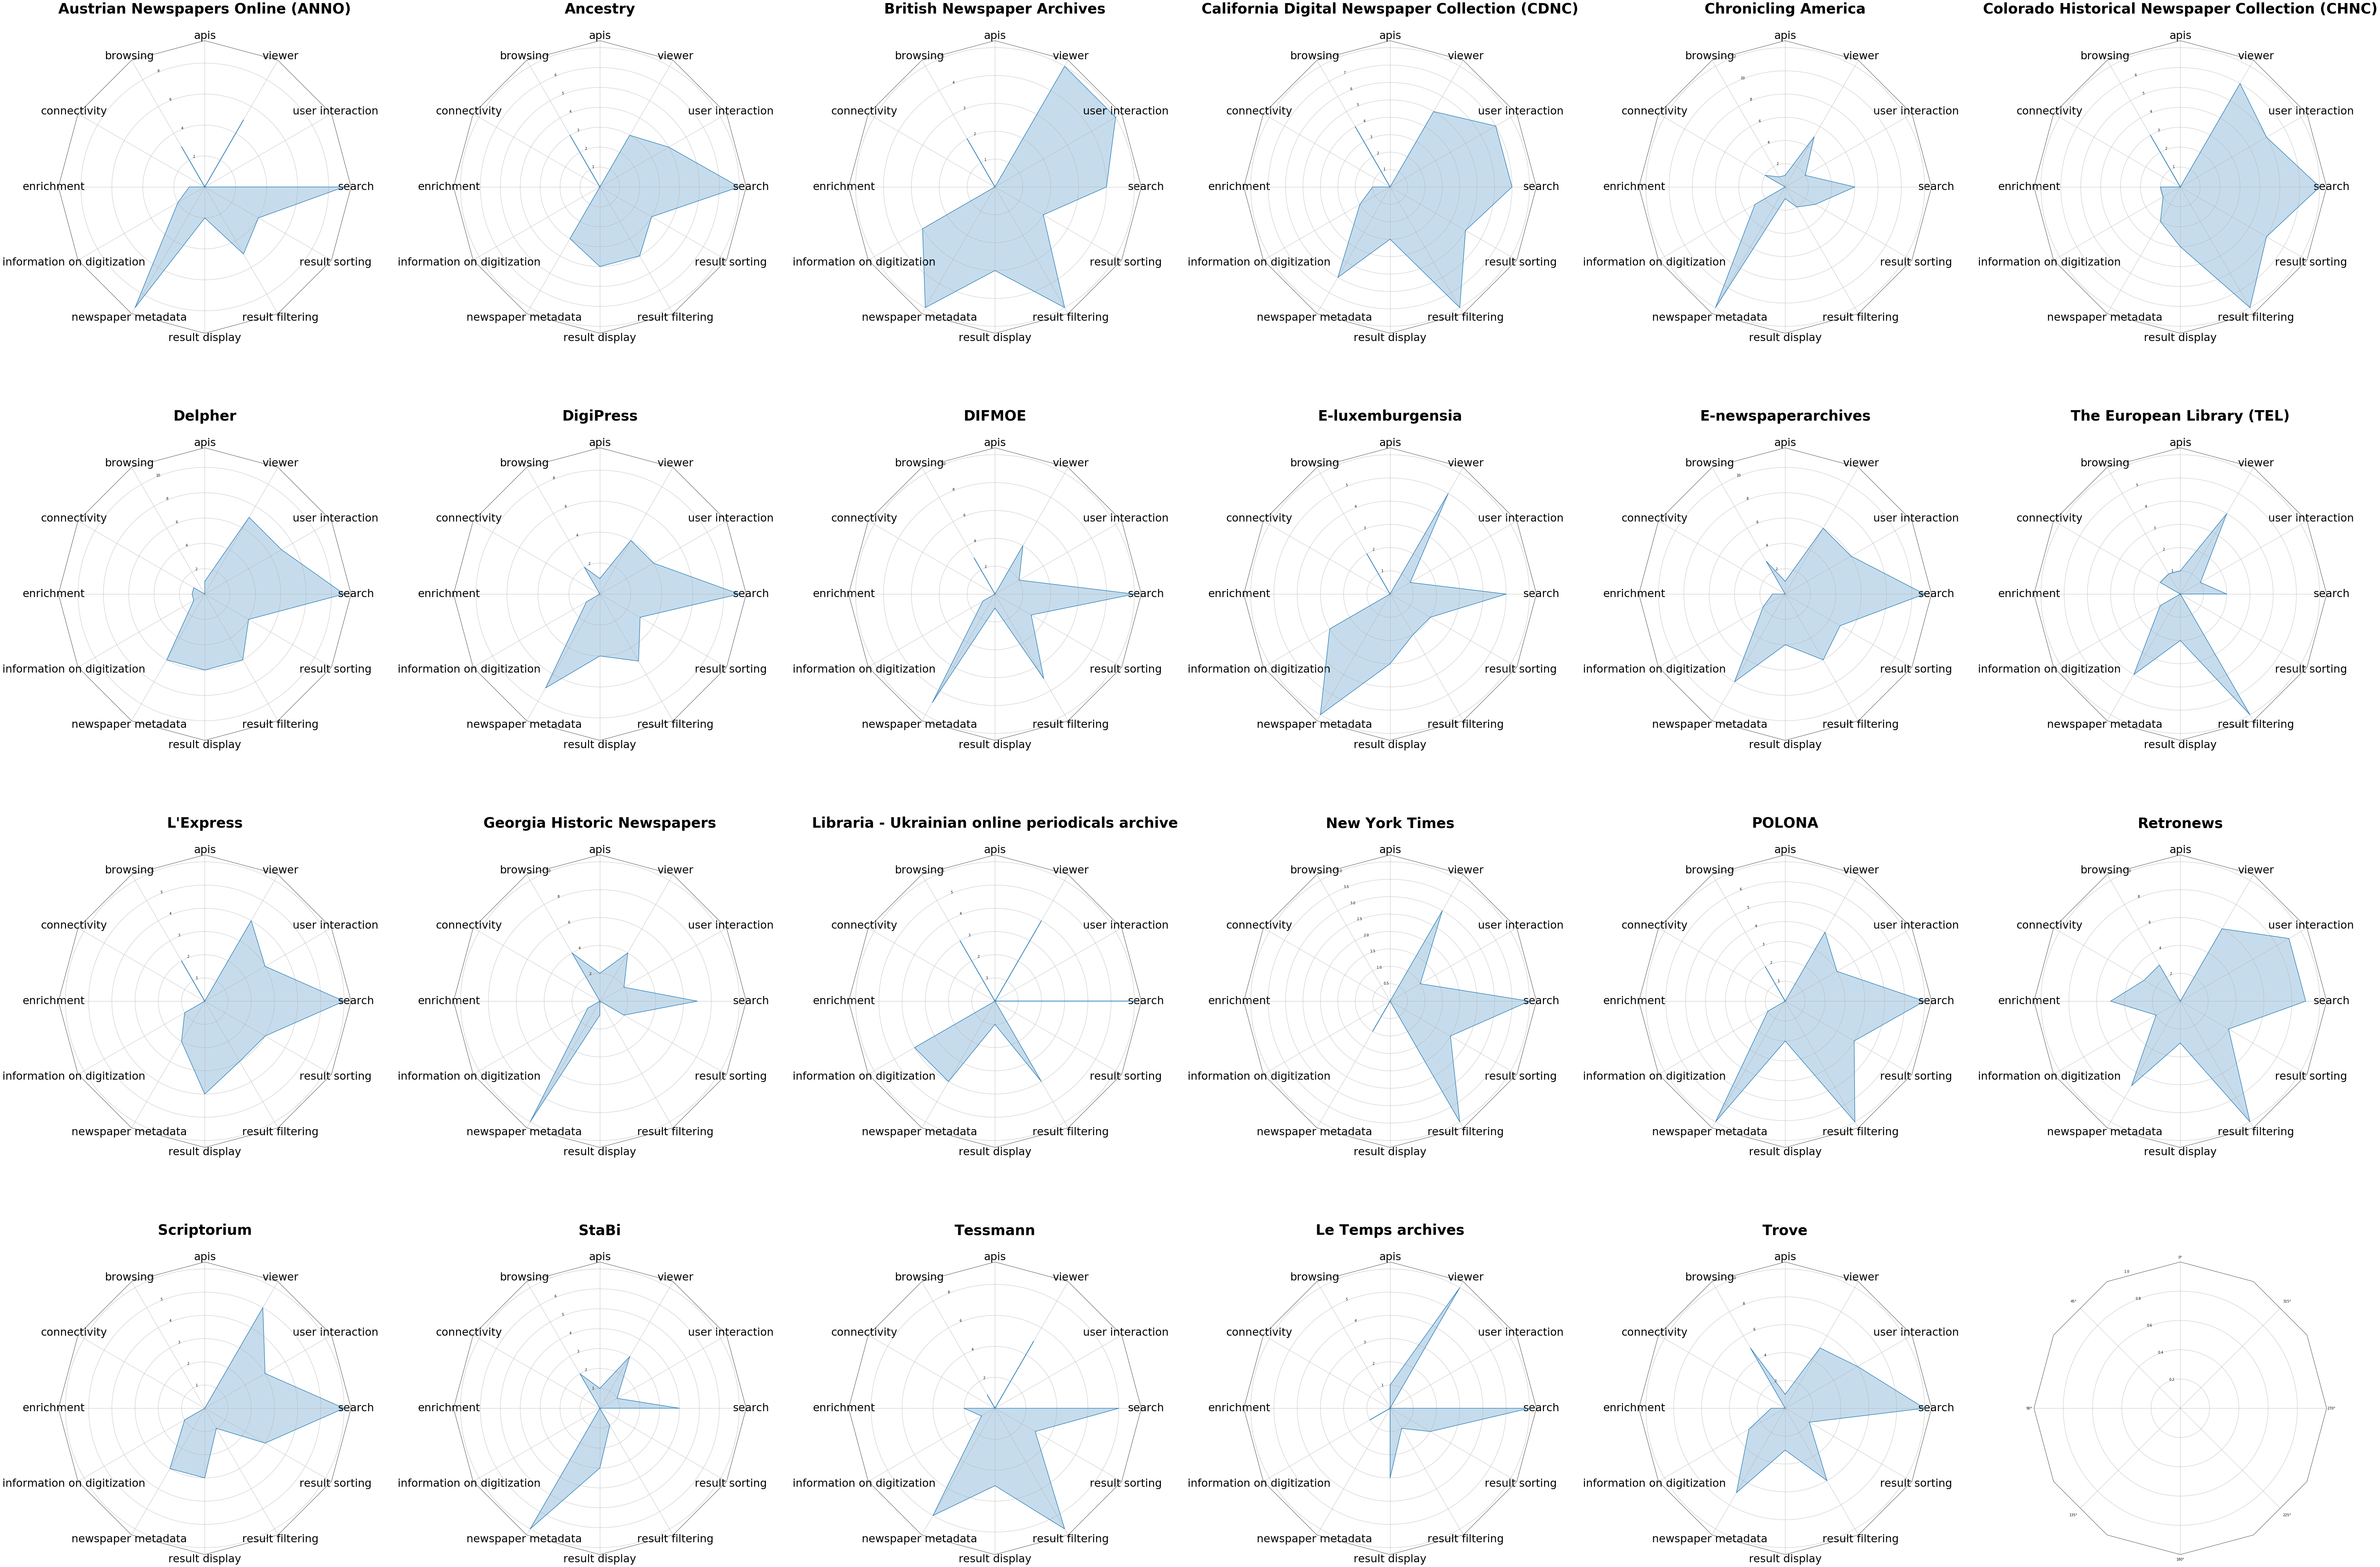

In [25]:
build_multiple_radar(labels, all_interfaces_counts, level_0.columns[:23], [10, 20, 30], 'interfaces-percent')

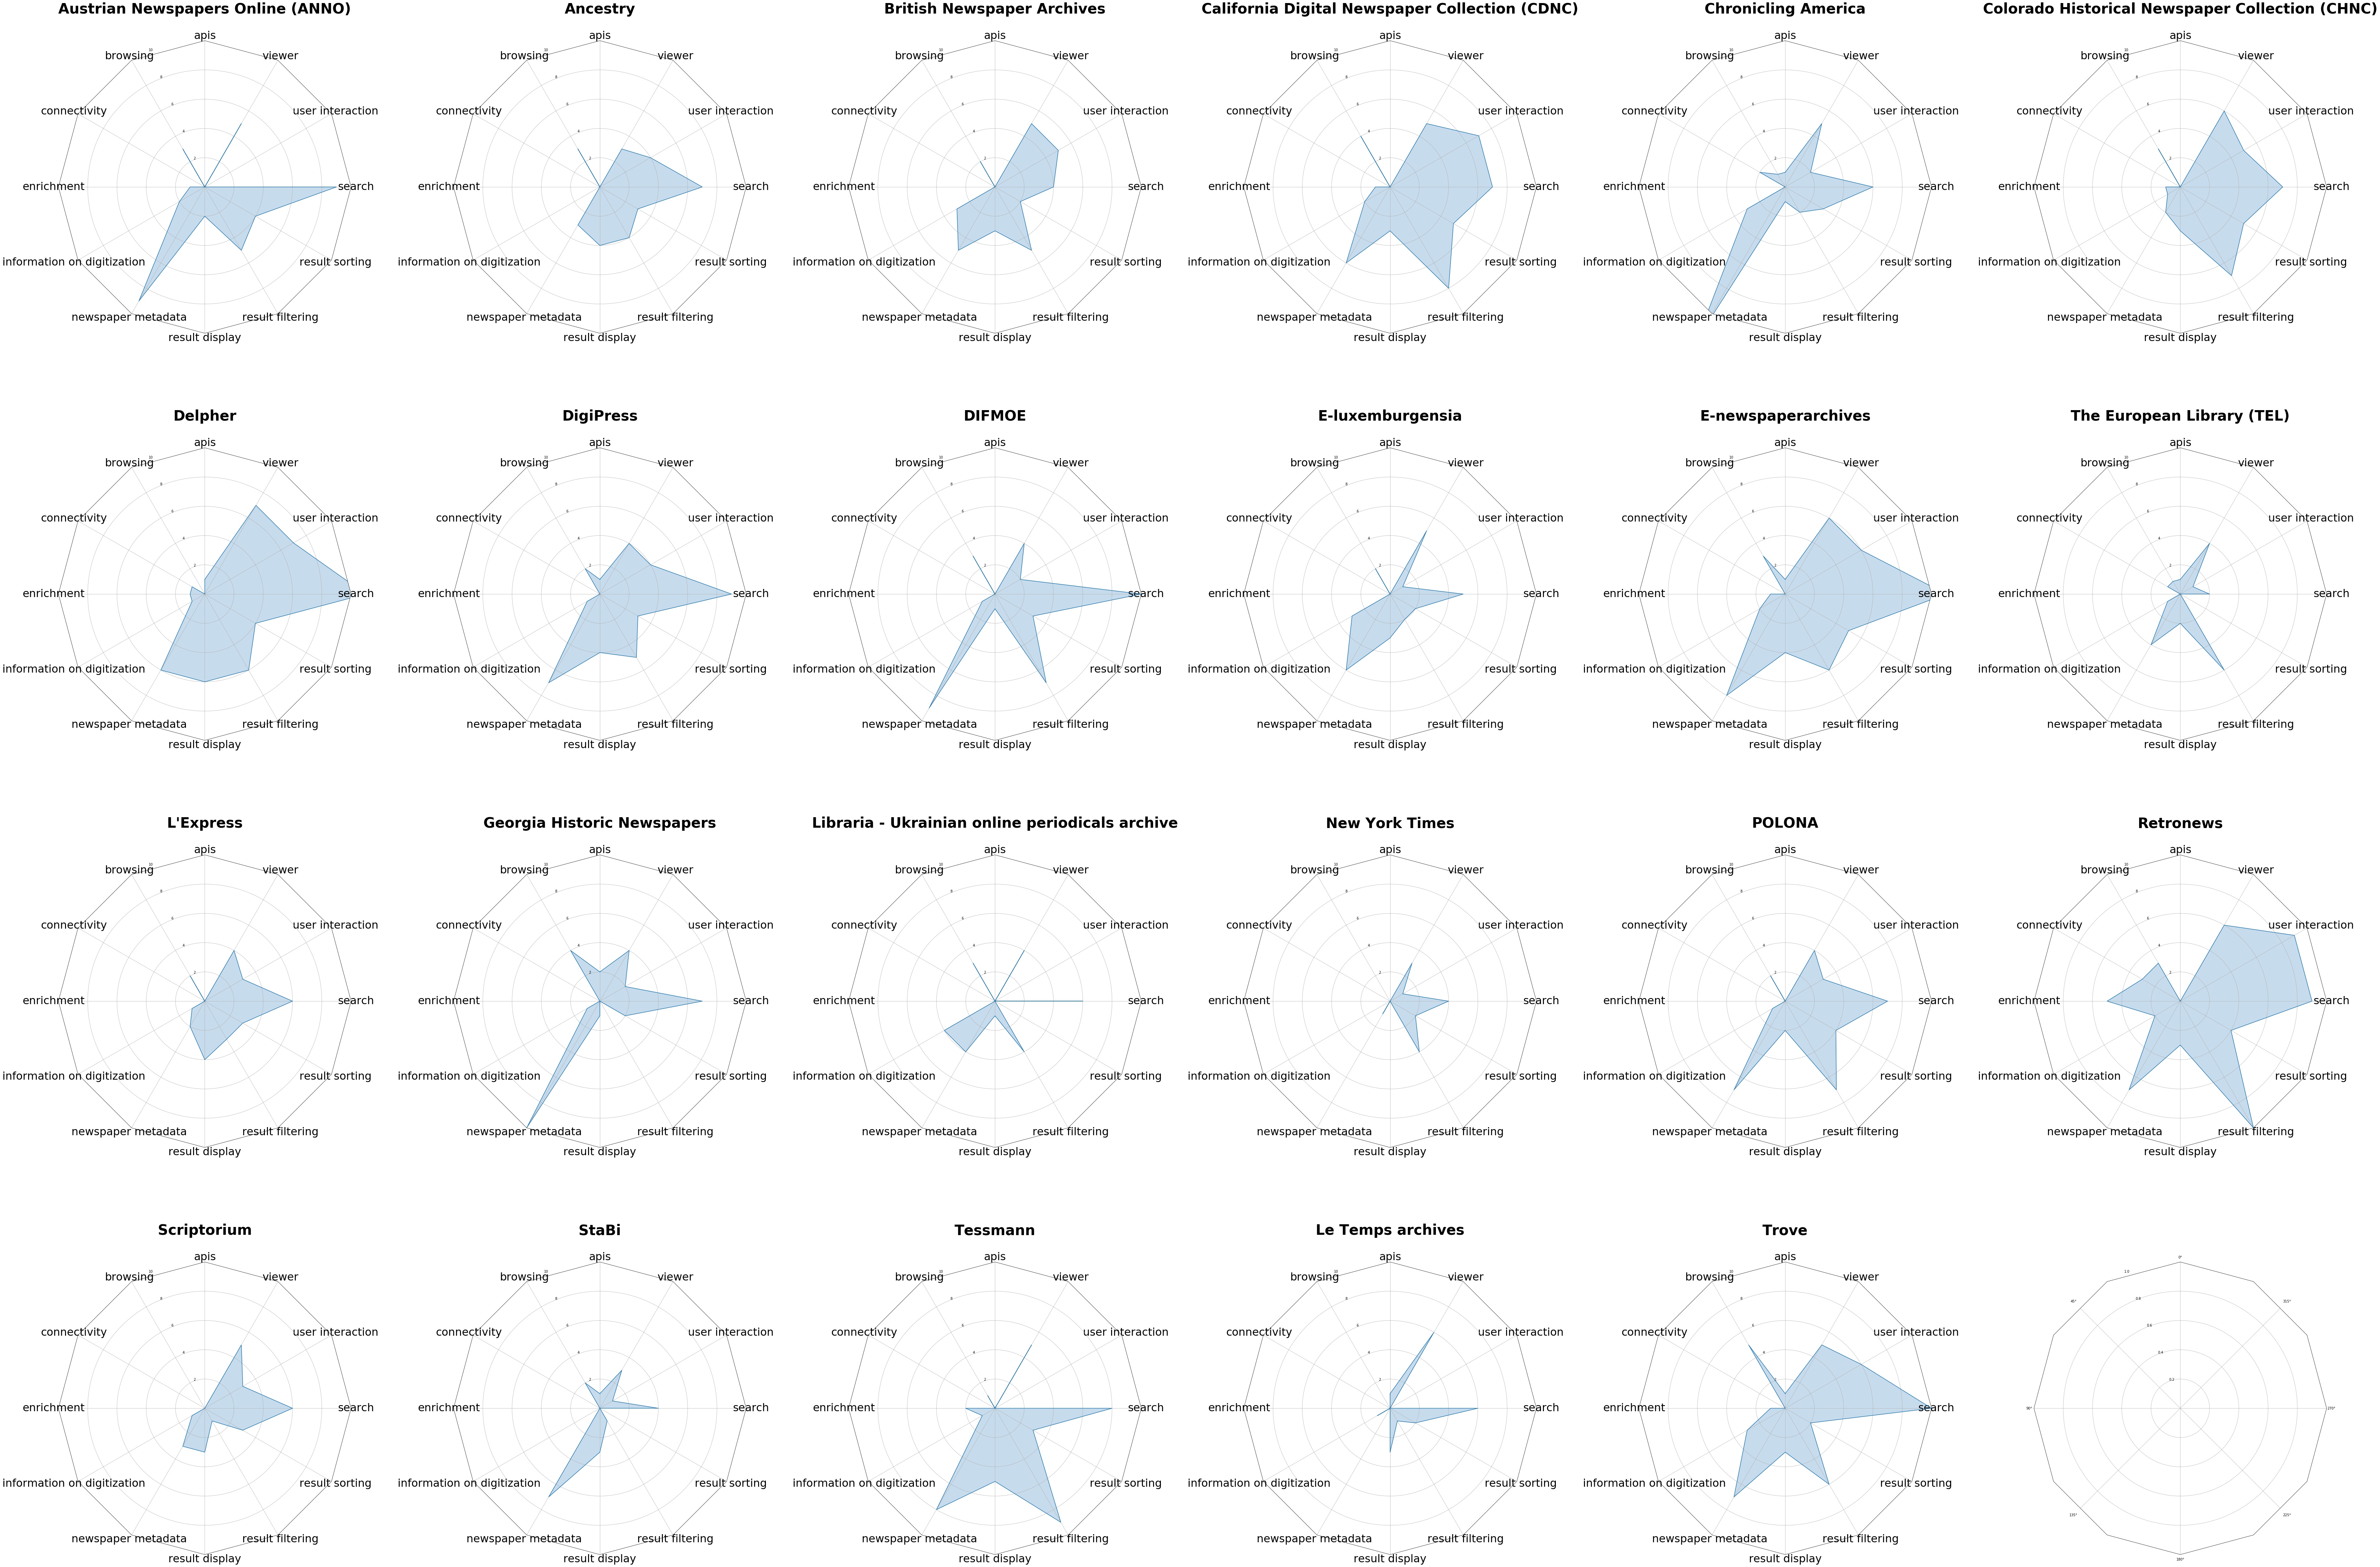

In [32]:
build_multiple_radar_even(labels, all_interfaces_counts, level_0.columns[:23], [10, 20, 30], 'interfaces-percent-even')

#### Global radar view (i.e. for all interfaces) over all features

In [ ]:
# take only the last column: Total per feature family, in percent
values = level_0.iloc[:,24:].T.values

In [ ]:
values

In [ ]:
build_single_radar(labels, values, "All interfaces",grid=[5,10,15,20],figure_title='global')

#### Global radar view focusing on Search (where there are a lot of features)

In [ ]:
search = base.loc['search'].copy()
search.loc[:,'Total'] = search.sum(axis=1)
search['Total (%)'] = search['Total']/search['Total'].sum() * 100

In [ ]:
search.head()

In [ ]:
labels_search = search.index

In [ ]:
labels_search

In [ ]:
values = search.iloc[:,25:].T.values

In [ ]:
values

In [ ]:
build_single_radar(labels_search, values, title=search.iloc[:,25:].index, grid=[2,4,6,8], figure_title="Search")

In [ ]:
build_single_radar(labels, values=first_interface, title="Search", grid=[2,4,6,8], figure_title=None)

In [ ]:
search.iloc[:,25:].index

In [38]:
level_0.loc['result filtering']['Retronews']

10.0